# <u> Hybrid Neural Network Model</u>


Given the superior performance of the Funk SVD model across both warm and cold items, a naive combination with content-based predictions using simple weighting is unlikely to improve results. However, content features such as tags and genres still carry valuable information that can complement the latent embeddings. The hybrid approach leverages the efficiency and high-quality representations learned by Funk SVD while allowing the model to integrate movie content through a flexible feedforward network to compensate for the initial absence of movie-specific information.

<br>

<div style="text-align: center;">
  <img src="images/Hybrid_NN_diagram.png" width="600">
</div>


**<u>Predictions</u>**

The hybrid model combines the pre-trained user and movie embeddings from the Funk SVD model with additional movie content features. The predicted rating for a user $u$ on a movie $i$ is computed as:

$$
\hat{r}_{u,i} = \mu + b_u + b_i + f(\mathbf{p}_u, \mathbf{q}_i, \mathbf{x}_i)
$$

where:  

- $\mu$ is the global mean rating across all users and movies  
- $b_u$ is the bias term for user $u$  
- $b_i$ is the bias term for movie $i$  
- $\mathbf{p}_u \in \mathbb{R}^k$ is the pre-trained embedding vector for user $u$ (from Funk SVD)  
- $\mathbf{q}_i \in \mathbb{R}^k$ is the pre-trained embedding vector for movie $i$ (from Funk SVD)  
- $\mathbf{x}_i \in \mathbb{R}^{d}$ represents the movie content feature vector (tags, genres, etc.)  
- $f(\mathbf{p}_u, \mathbf{q}_i, \mathbf{x}_i)$ is a feedforward neural network that learns a non-linear combination of the embeddings and content features to predict the rating

<br>

**<u>Training and Iterative Updates</u>**

The SVD embeddings are frozen based on the optimal hyperparameters found early on via validation, along with the movie feature vectors previously used by the content-based model. In contrast, the weights and biases of the neural network are trained to minimize the mean squared error over observed ratings. This process is iteratively computed using mini-batch gradient descent over the training set. The goal is to learn a function that predicts ratings more accurately than the original dot product of the pre-trained embeddings, while incorporating additional movie information.

<br>

**<u>Hyperparameter Selection</u>**

The three key hyperparameters evaluated on the validation set are:

- Neural network architecture, in terms of layer depth and width, reflecting the complexity of the function we want to learn  
- Learning rate, which controls how efficiently the model iteratively approaches the optimal parameters  
- Weight decay (L2 regularization), used primarily to limit overfitting on the validation set and warm items

<br>

**<u>Implementation</u>**

The model is implemented in PyTorch, providing full flexibility to combine collaborative embeddings with content features in a neural network framework. The setup supports mini-batch training to improve optimization stability and parallelization of the learning process.


## <u>0. Setting:</u>

### <u>0.1 Import libraries</u>

In [1]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys
import time
import matplotlib.pyplot as plt
import pickle
import torch
from itertools import product

# Remove userwarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Set the working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
from modules.hybrid_NN import *

### <u>0.2 Import pre-built datasets</u>

For consistency with the previous experiments, we adopt the same **time-based train–validation–test split**. For each user, the **earliest 70% of ratings** are used for training, the **next 10% for validation**, and the **most recent 20% for testing**. This ensures a fair comparison across models while preventing information leakage into the evaluation set. Additionally, given the hybrid nature of the hybrid algorithm, which jointly leverages **collaborative interactions and content-based features**, the movie feature vectors constructed in `05_content_F.ipynb` are used as item-information.

Following the evaluation protocol used for collaborative and model-based approaches, RMSE is reported on the full test set as well as separately for **warm-start** and **cold-start** settings. The cold-start subset corresponds to movies with fewer than 10 interactions in the training set, where predictions rely more heavily on content features rather than collaborative signals. Additionally, Hyperparameter tuning is performed on the validation set, and the total training and evaluation time is reported to enable computational performance comparisons.


In [2]:
# Load dataframe over the columns of interest
train_df = pd.read_csv('../data/processed/train_df.csv')
val_df = pd.read_csv('../data/processed/val_df.csv')
test_df = pd.read_csv('../data/processed/test_df.csv')
warm_test_df = pd.read_csv('../data/processed/warm_test_df.csv')
cold_test_df = pd.read_csv('../data/processed/cold_test_df.csv')


In [3]:
train_df.head(2)

,userId,movieId,rating
0,27,2683,5.0
1,27,2997,3.0


In [4]:
# Find length of training set, test and validation sets
train_length = len(train_df)
val_length = len(val_df)
test_length = len(test_df)
print(f"Training set length: {train_length//1000}k")
print(f"Validation set length: {val_length//1000}k")
print(f"Test set length: {test_length//1000}k")

Training set length: 592k
Validation set length: 85k
Test set length: 172k


## <u>1. Data Preparation:</u>

### <u>1.1 Movie Vector</u>

In terms of the movie vector, we rely entirely on the representation prebuilt in `05_content_F.ipyn`, which incorporates the following features. All features are standardized when necessary, following the principles defined in the previous notebook:

- `year`: Year of release, providing a precise temporal description.
- `decade`: Decade of release, offering a broader temporal representation to capture long-term movie trends and sequel effects.
- `G_`: Movie genres, where the 19 distinct genres are encoded using one-hot encoding, providing a categorical representation of movie type.
- `Bayes_rating`: Bayesian-adjusted rating, included to capture overall movie quality and community appraisal.
- `popularity`: Movie popularity, measured by the number of reviews to reflect audience reach.
- `tagPCA_`: Tag relevance scores, incorporating user-provided semantic information (140 PCA components built from the original 1,128 tags).


In [5]:
# Movie vectors prebuilt in 05_content_F.ipynb
movies_vector_std = pd.read_csv('../data/processed/movies_vector_std.csv')
movies_vector_std.head(2)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,tagPCA_205,tagPCA_206,tagPCA_207,tagPCA_208,tagPCA_209,tagPCA_210,tagPCA_211,tagPCA_212,tagPCA_213,tagPCA_214
0,1,0.162763,0.136589,0,1,1,1,1,0,0,...,-0.039740,-0.044172,-0.030774,-0.046569,0.098974,0.053088,0.052955,0.057731,0.013880,-0.035702
1,2,0.162763,0.136589,0,1,0,1,0,0,0,...,-0.095759,0.114656,-0.192151,0.064039,-0.044466,-0.056244,-0.062428,-0.023130,-0.025338,0.035913


### <u>1.2 Pre-Trained SVD</u>

In [6]:
# Import pre-trained SVD features
with open("../notebooks/pre_trained_SVD/svd_features.pkl", "rb") as f:
    svd_features = pickle.load(f)


# Analyze the content of svd_features
svd_features.keys()

dict_keys(['n_users', 'n_items', 'global_mean', 'user_bias', 'item_bias', 'user_factors', 'item_factors'])

As a first adjustment, we include zero-padding for `userId` and `movieId` that are not present in the training set. This ensures that cold users and items are correctly handled by assigning a zero vector for embeddings and a zero scalar for biases in the overall prediction. During this process, the index mapping is created by keeping track of the `UserId` and `MovieId` available in the extracted SVD features, which allows proper mapping of the training, validation, and test dataframes. Finally, all components are converted into tensors, enabling efficient handling by the PyTorch model class and its modules.

Given the subset nature of the training set over the whole set, the `movies_vector_std`will be used to genreate the index as it ensure that prebuilt feature of static movie still can provide vlauable insight in the construction rathr ethan be assinged to 0. For the SVD components by contrast we use only the index that intersect the two group of movies ID as unseen movie in the trianign are assidgend to 0 in those features.

In [7]:
# User index mapping (raw_id -> index)
user2idx = {uid: i+1 for i, uid in enumerate(svd_features['user_factors'].keys())}
n_users = svd_features['n_users'] + 1  

# Item index mapping (raw movieId -> index) 
# THe indexing is built over movies_vector_std as svd_feature is a subset of it in term of movies
movie_ids = movies_vector_std['movieId'].values
item2idx = {mid: i+1 for i, mid in enumerate(movie_ids)}
n_items = len(movie_ids) + 1  

# Embedding dimension of SVD features
emb_dim = list(svd_features['user_factors'].values())[0].shape[0]

# User factors tensor
user_factors = torch.zeros((n_users, emb_dim), dtype=torch.float32)
for uid, vec in svd_features['user_factors'].items():
    user_factors[user2idx[uid]] = torch.tensor(vec, dtype=torch.float32)

# Item factors tensor (populate only for items present in svd_features) 
item_factors = torch.zeros((n_items, emb_dim), dtype=torch.float32)
for iid, vec in svd_features['item_factors'].items():
    if iid in item2idx:
        item_factors[item2idx[iid]] = torch.tensor(vec, dtype=torch.float32)

# User biases tensor
user_bias = torch.zeros(n_users, dtype=torch.float32)
for uid, b in svd_features['user_bias'].items():
    user_bias[user2idx[uid]] = float(b)

# Item biases tensor(populate only for items present in svd_features)
item_bias = torch.zeros(n_items, dtype=torch.float32)
for iid, b in svd_features['item_bias'].items():
    if iid in item2idx:
        item_bias[item2idx[iid]] = float(b)

# Global mean
global_mean = float(svd_features['global_mean'])


Based on the constructed index, the training, validation, and test sets are reindexed accordingly to ensure correct handling by the model.

In [8]:
# Map raw IDs to indices for model input
train_df['user_idx'] = train_df['userId'].map(lambda x: user2idx.get(x, 0))
train_df['item_idx'] = train_df['movieId'].map(lambda x: item2idx.get(x, 0))

val_df['user_idx'] = val_df['userId'].map(lambda x: user2idx.get(x, 0))
val_df['item_idx'] = val_df['movieId'].map(lambda x: item2idx.get(x, 0))

test_df['user_idx'] = test_df['userId'].map(lambda x: user2idx.get(x, 0))
test_df['item_idx'] = test_df['movieId'].map(lambda x: item2idx.get(x, 0))

warm_test_df['user_idx'] = warm_test_df['userId'].map(lambda x: user2idx.get(x, 0))
warm_test_df['item_idx'] = warm_test_df['movieId'].map(lambda x: item2idx.get(x, 0))

cold_test_df['user_idx'] = cold_test_df['userId'].map(lambda x: user2idx.get(x, 0))
cold_test_df['item_idx'] = cold_test_df['movieId'].map(lambda x: item2idx.get(x, 0))

Movie features are also reindexed to match the corresponding movie IDs, ensuring correct handling during the training process.

In [9]:
# Movie features tensor
feature_dim = movies_vector_std.shape[1] - 1 
movie_tensor = torch.zeros((n_items, feature_dim), dtype=torch.float32)


# Map movie features to tensor using existing item2idx
movieid_to_row = {mid: idx for idx, mid in enumerate(movies_vector_std['movieId'].values)}
for mid, i in item2idx.items():
    if mid in movieid_to_row:
        row_idx = movieid_to_row[mid]
        movie_tensor[i] = torch.tensor(
            movies_vector_std.drop(columns=['movieId']).iloc[row_idx].values,
            dtype=torch.float32
        )


# Define content dimension
content_dim = movie_tensor.shape[1]

## <u>2. Hyperaparameter Tuning:</u>

In [10]:
# Hyperparameter grid
hidden_dims_list = [(32,), (64,), (64, 32)] # Architecture neural networks
lr_list = [5e-5, 1e-4, 3e-4]                # Learning rates  
batch_size_list = [512, 1024]               # Batch sizes
weight_decay_list = [0.0, 1e-5]             # Weight decay (L2 regularization)

max_epochs = 25
device = "cpu"

total_comb = (
    len(hidden_dims_list)
    * len(lr_list)
    * len(batch_size_list)
    * len(weight_decay_list)
)

comb_idx = 0
print_interval = max(1, total_comb // 5)  # ~20% progress updates
total_digits = len(str(total_comb))

In [11]:
# Random seed for reproducibility
torch.manual_seed(12)
np.random.seed(12)


# Tracking best model and parameters
best_params = None
best_epoch = None
best_val_loss = float("inf")
best_history = None
best_model = None


# Loop over all hyperparameter combinations
for hidden_dims in hidden_dims_list:
    for lr in lr_list:
        for batch_size in batch_size_list:
            for weight_decay in weight_decay_list:

                comb_idx += 1


                # Print start, end and each 20% progress
                should_print = (
                    comb_idx == 1
                    or comb_idx == total_comb
                    or comb_idx % print_interval == 0
                )

                if should_print:
                    counter = f"[{comb_idx:>{total_digits}}/{total_comb}]"
                    print(
                        f"{counter} Testing hidden_dims={hidden_dims}, "
                        f"lr={lr}, batch_size={batch_size}, "
                        f"weight_decay={weight_decay}...",
                        flush=True
                    )


                # Build model
                model = HybridNN(
                    user_factors=user_factors,
                    item_factors=item_factors,
                    user_bias=user_bias,
                    item_bias=item_bias,
                    global_mean=global_mean,
                    content_dim=content_dim,
                    hidden_dims=hidden_dims
                )

                # Train once
                model, history = train_hybrid_model(
                    model=model,
                    train_df=train_df,
                    val_df=val_df,
                    content_features=movie_tensor,
                    user2idx=user2idx,
                    item2idx=item2idx,
                    n_epochs=max_epochs,
                    batch_size=batch_size,
                    lr=lr,
                    weight_decay=weight_decay,
                    device=device,
                    val_epochs=None,
                    verbose=False
                )

                # Best epoch for this configuration
                val_losses = np.array(history["val_loss"])
                comb_best_val = val_losses.min()
                comb_best_epoch = val_losses.argmin() + 1

                if should_print:
                    print(
                        f"{' ' * len(counter)} "
                        f"Best Val Loss: {comb_best_val:.4f} "
                        f"at epoch {comb_best_epoch}"
                    )

                # Update global best
                if comb_best_val < best_val_loss:
                    best_val_loss = comb_best_val
                    best_epoch = comb_best_epoch
                    best_params = {
                        "hidden_dims": hidden_dims,
                        "lr": lr,
                        "batch_size": batch_size,
                        "weight_decay": weight_decay
                    }
                    best_history = history
                    best_model = model


# Print end statement
print("=" * 50)
print(
    "Best hyperparameters:\n\n"
    f"hidden_dims={best_params['hidden_dims']}, "
    f"lr={best_params['lr']}, "
    f"batch_size={best_params['batch_size']}, "
    f"weight_decay={best_params['weight_decay']},\n"
    f"best_epoch={best_epoch}, "
    f"Validation Loss={best_val_loss:.4f}"
)

[ 1/36] Testing hidden_dims=(32,), lr=5e-05, batch_size=512, weight_decay=0.0...
        Best Val Loss: 0.6563 at epoch 10
[ 7/36] Testing hidden_dims=(32,), lr=0.0001, batch_size=1024, weight_decay=0.0...
        Best Val Loss: 0.6570 at epoch 8
[14/36] Testing hidden_dims=(64,), lr=5e-05, batch_size=512, weight_decay=1e-05...
        Best Val Loss: 0.6524 at epoch 8
[21/36] Testing hidden_dims=(64,), lr=0.0003, batch_size=512, weight_decay=0.0...
        Best Val Loss: 0.6543 at epoch 1
[28/36] Testing hidden_dims=(64, 32), lr=5e-05, batch_size=1024, weight_decay=1e-05...
        Best Val Loss: 0.6574 at epoch 8
[35/36] Testing hidden_dims=(64, 32), lr=0.0003, batch_size=1024, weight_decay=0.0...
        Best Val Loss: 0.6604 at epoch 1
[36/36] Testing hidden_dims=(64, 32), lr=0.0003, batch_size=1024, weight_decay=1e-05...
        Best Val Loss: 0.6574 at epoch 1
Best hyperparameters:

hidden_dims=(64,), lr=5e-05, batch_size=1024, weight_decay=1e-05,
best_epoch=11, Validation Loss=0.

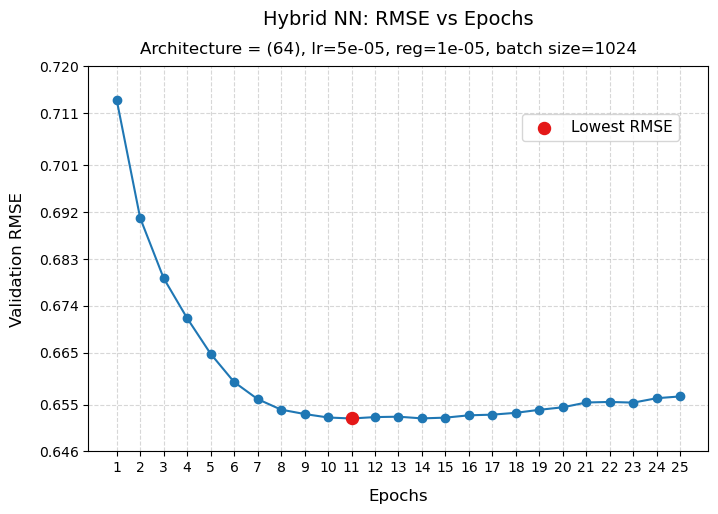

In [27]:
# Extract best RMSE history
best_rmse_history = best_history['val_loss']
n_epochs_list = list(range(1, max_epochs + 1))

plt.figure(figsize=(8,5))

# Plot validation RMSE curve
plt.plot(n_epochs_list, best_rmse_history, 'o-', color='#1f77b4')

# Highlight lowest RMSE (red)
min_epoch = n_epochs_list[best_rmse_history.index(min(best_rmse_history))]
plt.scatter(min_epoch, min(best_rmse_history),
            color="#e41818", marker='o', s=75, zorder=5, label='Lowest RMSE')  

# Labels, title, and subtitle with hyperparameters
plt.xlabel("Epochs", fontsize=12, labelpad=10) 
plt.ylabel("Validation RMSE", fontsize=12, labelpad=10)
plt.title("Hybrid NN: RMSE vs Epochs", fontsize=14, pad=30) 
plt.suptitle(f"Architecture = (64), lr={best_params['lr']}, reg={best_params['weight_decay']}, batch size={best_params['batch_size']}",
             fontsize=12, y=0.93)  

# Grid, ticks, and axis formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(n_epochs_list)

# Add vertical buffer
y_min, y_max = min(best_rmse_history), max(best_rmse_history)
y_buffer = (y_max - y_min) * 0.1
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Make y-axis ticks rounded to 3 decimals
y_ticks = np.round(np.linspace(y_min - y_buffer, y_max + y_buffer, 9), 3)
plt.yticks(y_ticks)

# Legend
plt.legend(frameon=True, bbox_to_anchor=(0.965, 0.8959), fontsize=11)

# Save and display
plt.savefig("../notebooks/images/hybrid_nn_rmse_vs_epochs.png", dpi=300, bbox_inches='tight')
plt.show()

<u> Comment:</u>

Given the concavity of the validation loss, and overall close epoch to the elbow method, epoch=11 was choosen on the validation loss. 

## <u> 3. Model Evaluation: </u>

In [26]:
# Set random seed for reproducibility
torch.manual_seed(12)
np.random.seed(12)

# Start timer
start_time = time.time()
best_epoch = 11

# Initialize the model with the best hyperparameters
model = HybridNN(
    user_factors=user_factors,
    item_factors=item_factors,
    user_bias=user_bias,
    item_bias=item_bias,
    global_mean=global_mean,
    content_dim=content_dim,
    hidden_dims=best_params['hidden_dims']
)

# Train the model on the full training set for the best number of epochs
model, history = train_hybrid_model(
    model=model,
    train_df=train_df,
    val_df=val_df,
    content_features=movie_tensor,
    user2idx=user2idx,
    item2idx=item2idx,
    n_epochs=best_epoch,
    batch_size=best_params['batch_size'],
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay'],
    device=device,
    val_epochs=None,
    verbose=True
)

# Evaluate on the test set
_, test_rmse = evaluate_hybrid_model(
    model=model,
    eval_df=test_df,            
    content_features=movie_tensor,  
    user2idx=user2idx,
    item2idx=item2idx,
    device=device
)

_, cold_rmse = evaluate_hybrid_model(
    model=model,
    eval_df=cold_test_df,            
    content_features=movie_tensor,  
    user2idx=user2idx,
    item2idx=item2idx,
    device=device
)

_, warm_rmse = evaluate_hybrid_model(
    model=model,
    eval_df=warm_test_df,            
    content_features=movie_tensor,  
    user2idx=user2idx,
    item2idx=item2idx,
    device=device
)


# Elapsed time
elapsed_time = time.time() - start_time

Epoch 1/11 | Train Loss: 0.7355 | Val Loss: 0.7178
Epoch 2/11 | Train Loss: 0.7002 | Val Loss: 0.6945
Epoch 3/11 | Train Loss: 0.6740 | Val Loss: 0.6815
Epoch 4/11 | Train Loss: 0.6566 | Val Loss: 0.6737
Epoch 5/11 | Train Loss: 0.6421 | Val Loss: 0.6673
Epoch 6/11 | Train Loss: 0.6287 | Val Loss: 0.6621
Epoch 7/11 | Train Loss: 0.6169 | Val Loss: 0.6587
Epoch 8/11 | Train Loss: 0.6070 | Val Loss: 0.6563
Epoch 9/11 | Train Loss: 0.5987 | Val Loss: 0.6556
Epoch 10/11 | Train Loss: 0.5917 | Val Loss: 0.6550
Epoch 11/11 | Train Loss: 0.5857 | Val Loss: 0.6546


In [28]:
print(
    f"Model performance (Hybrid NN) on test set \n"
    f"(hidden_dims={best_params['hidden_dims']}, batch_size={best_params['batch_size']}, lr={best_params['lr']},"
    f"weight_decay={best_params['weight_decay']}, epochs={best_epoch}):\n"
    f"RMSE Total: {test_rmse:.4f}\n"
    f"RMSE Warm:  {warm_rmse:.4f}\n"
    f"RMSE Cold:  {cold_rmse:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)

Model performance (Hybrid NN) on test set 
(hidden_dims=(64,), batch_size=1024, lr=5e-05,weight_decay=1e-05, epochs=11):
RMSE Total: 0.8317
RMSE Warm:  0.8282
RMSE Cold:  0.8880
Elapsed time: 50.2 seconds


## <u> 4. Summary of findings </u>

### <u> 4.1 Model performance </u>


<div style="display: flex; justify-content: left; align-items: flex-start;">
  <img src="images/Hybrid_NN_diagram.png" style="height: 350px; margin-right: 20px;">
  <img src="images/hybrid_nn_rmse_vs_epochs.png" style="height: 350px;">
</div>


<br>

<table border="1" cellpadding="5" cellspacing="0" style="text-align: center;">
  <tr>
    <th>Model Type</th>
    <th>Validation RMSE</th>
    <th colspan="3">Test RMSE</th>
    <th>Elapsed Time (s)</th>
  </tr>
  <tr>
    <th></th>
    <th>Total</th>
    <th>Total</th>
    <th>Warm</th>
    <th>Cold</th>
    <th></th>
  </tr>
  <tr>
    <td>Hybrid NN</td>
    <td>0.6546</td>
    <td>0.8317</td>
    <td>0.8282</td>
    <td>0.8880</td>
    <td>50.2</td>
  </tr>
</table>


### <u> 4.2 Discussion </u>


From the results we can observe that the hybrid neural network provides a modest but noticeable improvement over the optimized Funk SVD model. In particular, the cold test RMSE decreases by approximately 2.5% (0.9105 → 0.8880), while the gains on the warm and overall test sets are smaller. By the use of this approach, the model is able to learn residual corrections on top of the pre-trained embeddings and biases, capturing interactions that are not fully represented by the baseline latent factors. The inclusion of movie content features provides additional information beyond the collaborative filtering signals, allowing the network to refine predictions for items with limited interaction history. Although the training time is slightly higher, the implementation in PyTorch allows for further acceleration through GPU mini-batch parallelization. One limitation of the current setup is the dense movie feature vector, which may constrain the model’s ability to generalize. Future work could explore feature selection or dimensionality reduction to enhance the residual learning and further improve performance.